In [1]:
# environment: labelmaker

# (2) 1. InternImage: I had to install:
        # pip install -U openmim
        # mim install mmsegmentation==0.27.0
    # because I got an error, and followed the suggestions here: https://github.com/OpenGVLab/InternImage/issues/208

# (3) 2. OVSeg: I had to do:
        # export PYTHONPATH=$PYTHONPATH:~/Desktop/LabelMaker # because some code used as "package" (from labelmaker.label_data import get_ade150, get_replica, get_wordnet) was in the GitHub repository of LabelMaker
    # I also had to install CLIP following these instructions, with some modifications: https://github.com/facebookresearch/ov-seg/blob/2a3a047973f9db3d3695d01098351f251ffc362e/INSTALL.md :
        # python -m pip install -U setuptools # got setuptools-70.0.0
        # cd third_party/CLIP # of the ov-seg GitHub repository
        # python -m pip install -Ue . # to install CLIP

# (1) 5. Mask3D: environment as provided by the LabelMaker GitHub page (installation done a bit differently, however. See the txt file I created)

In [6]:
import open3d as o3d
import os
import numpy as np
import scannet200_constants # local file. From https://github.com/cvg/Mask3D/blob/e07b115fb7830d600f9db865489612f5739bbb50/mask3d/datasets/scannet200/scannet200_constants.py
import matplotlib.pyplot as plt

import cv2
from labelmaker.visualisation import draw_sem_seg, VisImage # local file
from labelmaker.label_data import get_ade150, get_wordnet # local file
import pyviz3d.visualizer as viz # local file

## LabelMaker - 0. Preparation

### ARKitScenes

If you want to download something from ARKitScenes (https://github.com/apple/ARKitScenes/tree/095a1190748be2c62d3f70f211352a31eac0172c?tab=readme-ov-file), I found the list of IDs of the scenes that can be used here: https://github.com/apple/ARKitScenes/blob/095a1190748be2c62d3f70f211352a31eac0172c/raw/raw_train_val_splits.csv

Additional information are here: https://github.com/apple/ARKitScenes/blob/095a1190748be2c62d3f70f211352a31eac0172c/DATA.md

First of all, one needs to download the ARKitScenes. **The following code has to be executed in the CMD, being in the root of the clone of the GitHub repository of LabelMaker**:

```bash
#
# Download scene
#
export TRAINING_OR_VALIDATION=Training
export SCENE_ID=47333462 # TODO TOSET: change with what you need

conda activate labelmaker

python 3rdparty/ARKitScenes/download_data.py raw --split $TRAINING_OR_VALIDATION --video_id $SCENE_ID --download_dir ~/Desktop/LabelMaker/ARKitScenes/ --raw_dataset_assets lowres_depth confidence lowres_wide.traj lowres_wide lowres_wide_intrinsics vga_wide vga_wide_intrinsics # TODO TOSET: in case change the paths and the things to be downloaded

#
# Convert scene to LabelMaker workspace
#

WORKSPACE_DIR=~/Desktop/LabelMaker/workspace/$SCENE_ID # TODO TOSET: change the path, in case

python scripts/arkitscenes2labelmaker.py --scan_dir ~/Desktop/LabelMaker/ARKitScenes/raw/$TRAINING_OR_VALIDATION/$SCENE_ID --target_dir $WORKSPACE_DIR # TODO TOSET: change the path, in case
```
	
	
In my case, I will find the things to work with in this directory: `/local/home/gmarsich/Desktop/LabelMaker/workspace/`

Then, to visualise the point cloud obtained after having used `scripts/arkitscenes2labelmaker.py`:

In [3]:
scene_id_num = 47333462 # TODO TOSET: change if needed
scene_id = str(scene_id_num)

# Show the original point cloud
pcd_original = o3d.io.read_point_cloud(os.path.join('/local/home/gmarsich/Desktop/LabelMaker/workspace', scene_id, 'mesh.ply')) # TODO TOSET: change the name of the point cloud to open
o3d.visualization.draw_geometries([pcd_original])

## LabelMaker - 1. InternImage

This part performs semantic segmentation using the InternImage model. *For an image of the ARKitScenes may take something like $1$ h and $30$ min.*

**The following code has to be executed in the CMD, being in the root of the clone of the GitHub repository of LabelMaker**:

```bash
conda activate labelmaker

export WORKSPACE_DIR=/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/47333462

python models/internimage.py --workspace $WORKSPACE_DIR
```

For each input image in the color subdirectory of the workspace, the script generates a segmentation result. The segmentation result is a labeled image where each pixel's value corresponds to a class label. The segmentation results are saved as PNG images in the output directory. Each output file has the same base name as the corresponding input file, but with a `.png` extension. The segmentation result images are saved in a format where the pixel values represent class labels. The pixel values are stored as 16-bit unsigned integers (`np.uint16`).

So, to understand the output (structure of the code taken from: https://github.com/cvg/LabelMaker/blob/main/notebooks/evaluation_labelmaker.ipynb):

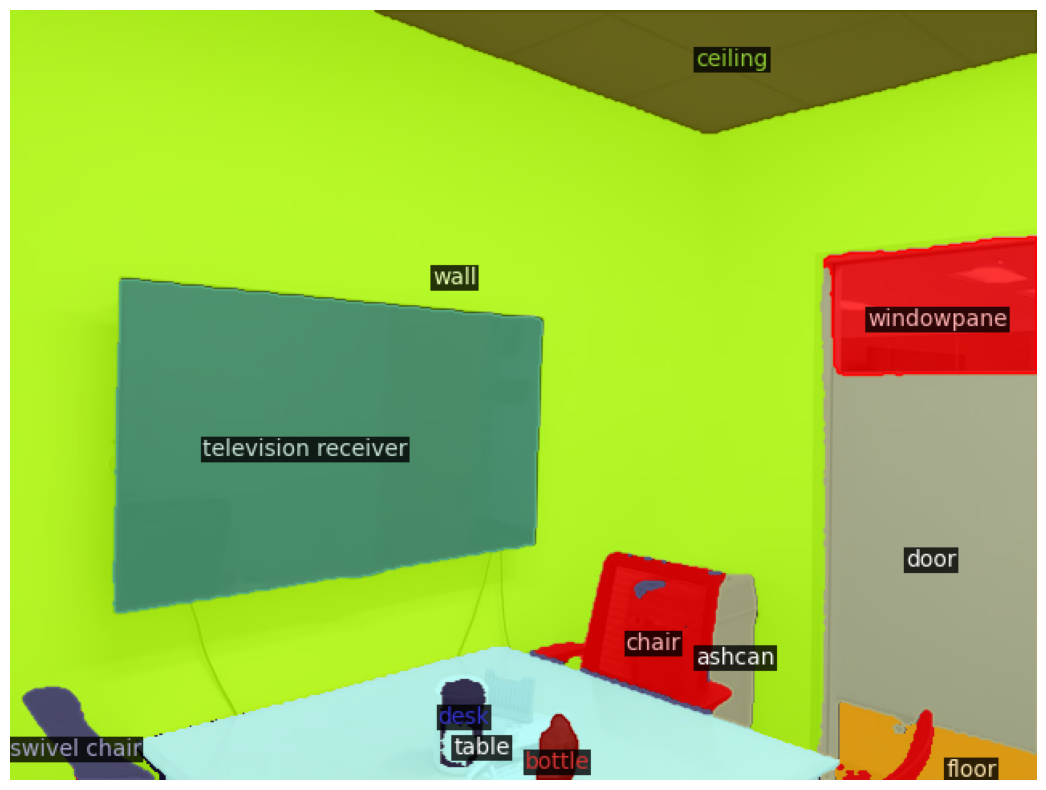

In [19]:
# TODO: you may find a way to set colors so that they are no more random.
    # IDEAS:
    # - use the label_mapping.csv file (LabelMaker/labelmaker/mappings/label_mapping.csv , from https://github.com/cvg/LabelMaker/blob/main/labelmaker/mappings/label_mapping.csv)
    # - use the array created by create_color_palette() in this notebook: https://github.com/cvg/LabelMaker/blob/main/notebooks/generate_3d_projections.ipynb

path_dir_img_color = '/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/40753679/color' #TODO TOSET
img_color_key = '000000' #TODO TOSET
img = cv2.imread(f'{path_dir_img_color}/{img_color_key}.jpg')[..., ::-1]

dir_ovseg = '/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/40753679/intermediate/ade20k_internimage_1' # TODO TOSET
ovseg = cv2.imread(f'{dir_ovseg}/{img_color_key}.png',
                    cv2.IMREAD_UNCHANGED)

vis = VisImage(img, scale=1)
draw_sem_seg(
    ovseg,
    vis,
    classes=[x['name'] for x in sorted(get_ade150(), key=lambda x: x['id'])])
plt.figure(figsize=(20, 10))
plt.imshow(vis.get_image())
plt.gca().axis('off')

plt.show()

## LabelMaker - 2. OVSeg

*For an image of the ARKitScenes may take something like $2$ h.*

Had to run:

```bash
python models/ovseg.py --workspace ~/data2TB/LabelMaker/processed_ARKitScenes/40753679
```

because using ```export WORKSPACE_DIR=~/data2TB/LabelMaker/processed_ARKitScenes/40753679``` did not work.

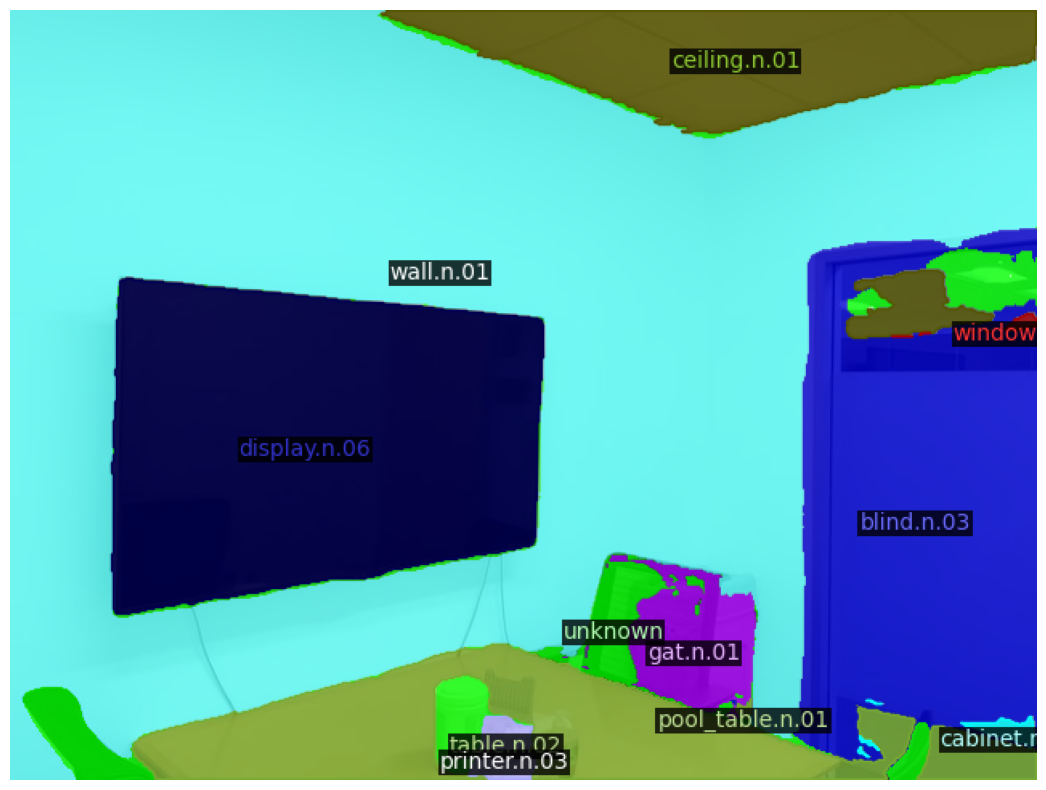

In [45]:
# TODO: you may find a way to set colors so that they are no more random.
    # IDEAS:
    # - use the label_mapping.csv file (LabelMaker/labelmaker/mappings/label_mapping.csv , from https://github.com/cvg/LabelMaker/blob/main/labelmaker/mappings/label_mapping.csv)
    # - use the array created by create_color_palette() in this notebook: https://github.com/cvg/LabelMaker/blob/main/notebooks/generate_3d_projections.ipynb

path_dir_img_color = '/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/40753679/color' #TODO TOSET
img_color_key = '000000' #TODO TOSET
img = cv2.imread(f'{path_dir_img_color}/{img_color_key}.jpg')[..., ::-1]

dir_ovseg = '/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/40753679/intermediate/wordnet_ovseg_1' # TODO TOSET
ovseg = cv2.imread(f'{dir_ovseg}/{img_color_key}.png',
                    cv2.IMREAD_UNCHANGED)

vis = VisImage(img, scale=1)
draw_sem_seg(
    ovseg,
    vis,
    classes=[x['name'] for x in sorted(get_wordnet(), key=lambda x: x['id'])],
    #colors=[x['color'] for x in sorted(get_wordnet(), key=lambda x: x['id'])] # TODO: if you want the colormap, you should adjust this, that now gives error
    )
plt.figure(figsize=(20, 10))
plt.imshow(vis.get_image())
plt.gca().axis('off')

plt.show()


## LabelMaker - 5. Mask3D

### Preprocess Hypersim scenes - Reduce occupied space

The Hypersim pointclouds are too big to be processed, and it does not make sense to insist with having super detailed point clouds.

In [ ]:
path_dir_pointclouds = '/local/home/gmarsich/data2TB/Hypersim/POINTCLOUDS' #TODO TOSET
name_pointcloud = 'point_cloud_DEPTHS_TONEMAP_ai_007_008_cam_00_METERS.ply' #TODO TOSET

pcd_mask3d = o3d.io.read_point_cloud(os.path.join(path_dir_pointclouds, name_pointcloud))

# # Remove duplicates of points and save a new pointcloud, but seems that the occupied memory is always the same
# pcd = pcd.remove_duplicated_points()
# name_pointcloud_noduplicates = os.path.splitext(name_pointcloud)[0] + '_NODUPLICATES.ply'
# new_path_pointcloud = os.path.join(path_dir_pointclouds, name_pointcloud_noduplicates)
# o3d.io.write_point_cloud(new_path_pointcloud, pcd)

# Undersample the point cloud
voxel_size = 0.03  # TODO TOSET: for point_cloud_DEPTHS_TONEMAP_ai_007_008_cam_00_METERS.ply voxel_size = 0.015 gives a point cloud of more or less 98 MB
downsampled_pcd = pcd_mask3d.voxel_down_sample(voxel_size)
name_pointcloud_downsampled = os.path.splitext(name_pointcloud)[0] + '_DOWNSAMPLED.ply'
new_path_pointcloud = os.path.join(path_dir_pointclouds, name_pointcloud_downsampled)
o3d.io.write_point_cloud(new_path_pointcloud, downsampled_pcd)

In [ ]:
# Show the downsampled point cloud
pcd_downsampled = o3d.io.read_point_cloud(os.path.join(path_dir_pointclouds, name_pointcloud_downsampled))
o3d.visualization.draw_geometries([pcd_downsampled])

### Things to do

Type of object, colour and ID in the segmentation respect the indications specified in this file: https://github.com/ScanNet/ScanNet/blob/master/BenchmarkScripts/ScanNet200/scannet200_constants.py

Now we want to perform the segmentation with Mask3D, that is also a part of the pipeline of LabelMaker. **The following code has to be executed in the CMD, being in the root of the clone of the GitHub repository of LabelMaker**:

IMPORTANT: the script will search for a file named `mesh.ply` in the `WORKSPACE_DIR`, so rename the file accordingly

```bash
conda activate labelmaker

WORKSPACE_DIR=~/Desktop/LabelMaker/workspace/47333462 # TODO TOSET: change the path, in case

python models/mask3d_inst.py --workspace $WORKSPACE_DIR # TODO TOSET: be sure that the WORKSPACE_DIR is what you need. Be aware that depending on the scene you have to change WORKSPACE_DIR
```

In my case, I will find this in the directory: `~/Desktop/LabelMaker/workspace/47333462/intermediate`

First of all let's build a legend showing what was found in the scene (that was represented with a point cloud):

In [8]:
#
# Get the list of objects that appear in the segmentation (use the files provided from the work of Mask3D)
#

base_path = "/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/40753679/intermediate/scannet200_mask3d_1" # TODO TOSET
path_predictions = os.path.join(base_path, "predictions.txt") # TODO TOSET: change if necessary

def build_legend(path_predictions):
    with open(path_predictions, 'r') as file:
        lines = file.readlines()

    predictions = []

    for line in lines:
        parts = line.strip().split()
        filename = parts[0]
        file_number = filename.split('/')[1].split('.')[0]
        object_ID = int(parts[1])
        confidence = float(parts[2])

        predictions.append([file_number, object_ID, confidence])

    # Build a list with the info that I need
    objects = []

    for prediction in predictions:
        object_ID = prediction[1]
        
        # Find the object_ID in the objects list
        found = False
        for obj in objects:
            if obj[0] == object_ID:
                obj[1] += 1
                found = True
                break
        
        # If the object_ID was not found, add it to the list with a count of 1
        if not found:
            objects.append([object_ID, 1])


    #
    # Build a big table with the correspondences between VALID_CLASS_IDS_200, CLASS_LABELS_200 and SCANNET_COLOR_MAP_200 from scannet200_constants
    #

    table_scannet200 = []

    for class_id, label in zip(scannet200_constants.VALID_CLASS_IDS_200, scannet200_constants.CLASS_LABELS_200):
        color = scannet200_constants.SCANNET_COLOR_MAP_200[class_id]
        table_scannet200.append((class_id, label, color))

    # An alternative could be to get the colours from the point cloud and search for their assciated IDs (and name of the object) on
        # https://github.com/ScanNet/ScanNet/blob/master/BenchmarkScripts/ScanNet200/scannet200_constants.py


    #
    # Use the big table to add information to the list objects
    #

    # Add label and colour
    for obj in objects:
        object_ID = obj[0]
        
        for entry in table_scannet200:
            class_id, label, color = entry
            if object_ID == class_id:
                obj.append(label)
                obj.append(color)
                break

    # Sort the objects list by the ID (first element of each sublist)
    objects.sort(key=lambda x: x[0])
    return objects


In [9]:
objects = build_legend(path_predictions)

Now each element of the list `objects` has $4$ elements:

- `objects[i][0]`: ID of the class

- `objects[i][1]`: number of instances of the class

- `objects[i][2]`: name of the class in English

- `objects[i][3]`: colour of the instances of the class in RGB (max values: $(255, 255, 255)$)

Let's get the image with the legend:


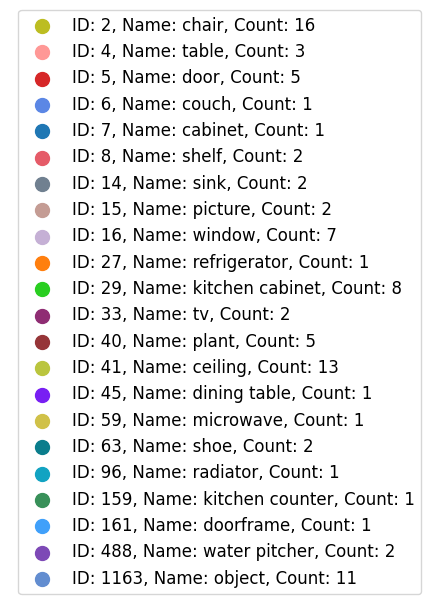

In [26]:
#
# Get the legend for objects in the scene
#

plt.figure(figsize=(0.001, len(objects) * 0.2))

# Loop over the objects and add them to the plot
for i, obj in enumerate(objects):
    object_ID = obj[0]
    count = obj[1]
    label = obj[2]
    color = [c/255 for c in obj[3]]  # normalize the color values

    plt.scatter([], [], c=[color], label=f'ID: {object_ID}, Name: {label}, Count: {count}', s=100)
    
# Create a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large')
plt.axis('off')
plt.show()

In [4]:
# Show the segmentation with Mask3D (computed by LabelMaker)
pcd_mask3D = o3d.io.read_point_cloud(os.path.join("/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes_ORIGINAL", str(scene_id), "intermediate/scannet200_mask3d_1/mesh_labelled.ply")) # TODO TOSET: change the name of the point cloud to open
o3d.visualization.draw_geometries([pcd_mask3D])

[Open3D WARNING] Read PLY failed: unable to open file: /local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes_ORIGINAL/40753679/intermediate/scannet200_mask3d_1/mesh_labelled.ply
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


RPly: Unable to open file


You may have already saved the point cloud. Select the point cloud you want to render with the labels:

In [15]:
# Show the point cloud
pcd_mask3D = o3d.io.read_point_cloud(os.path.join("/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/40753679/intermediate/scannet200_mask3d_1/mesh_labelled.ply")) # TODO TOSET: change the name of the point cloud to open
#o3d.visualization.draw_geometries([pcd_mask3D])

Let's now render the point cloud with the legend. I used the `PyViz3D` package (https://github.com/francisengelmann/PyViz3D/tree/master?tab=readme-ov-file) and took inspiration from a couple of example codes that were provided (https://github.com/francisengelmann/PyViz3D/blob/master/examples/example_text.py , https://github.com/francisengelmann/PyViz3D/blob/master/examples/example_point_clouds.py).



Get `sorted_txt_paths`, the list of path to the `pred_mask` files:

In [25]:
path_pred_masks = "/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/40753679/intermediate/scannet200_mask3d_1/pred_mask" #TODO TOSET
all_files = os.listdir(path_pred_masks)
txt_files = [f for f in all_files if f.endswith('.txt')]

def extract_number(filename):
    return int(os.path.splitext(filename)[0])

txt_files.sort(key=extract_number)
sorted_txt_paths = [os.path.join(path_pred_masks, f) for f in txt_files]

Get `list_labels`, a list where each element is of the form `[label, position, color]` (one element for each instance that appears in the segmentation), and its transposed `transposed_list_labels`:

In [26]:
with open(path_predictions, 'r') as file:
    lines = file.readlines()


list_labels = [] # will contain a list of [label, position, color]

def get_centroid(path_pred_mask, pcd_mask3D):
    points = np.asarray(pcd_mask3D.points)
    with open(path_pred_mask, 'r') as f:
        mask = np.array([int(line.strip()) for line in f])
    assert len(mask) == len(points)
    selected_points = points[mask == 1]
    centroid = np.mean(selected_points, axis=0)
    return centroid

for i, path_pred_mask in enumerate(sorted_txt_paths):
    parts = lines[i].strip().split()
    object_ID = int(parts[1])
    label = None
    color = None
    position = get_centroid(path_pred_mask, pcd_mask3D)
    for index in range(len(objects)):
        if objects[index][0] == object_ID:
            label = objects[index][2]
            color = objects[index][3]
            #break
    list_labels.append([label, position, color])
    
transposed_list_labels = [list(row) for row in zip(*list_labels)]


Set up a visualizer `v` that will basically contain the point cloud and the labels. Afterwards, the rendering has to be performed on a browser following the output given by the following cell:

In [43]:
# First, we set up a visualizer
v = viz.Visualizer()

name = 'Point cloud'
point_positions = np.asarray(pcd_mask3D.points)
point_colors = (np.asarray(pcd_mask3D.colors) * 255).astype(np.uint8)
point_size = 10

# Here we add point clouds and labels to the visualizer
v.add_points(name, point_positions, point_colors, point_size=point_size, visible=False)
v.add_labels(name ='Labels',
                 labels = transposed_list_labels[0],
                 positions = transposed_list_labels[1],
                 colors = transposed_list_labels[2],
                 visible=True)

# When we added everything we need to the visualizer, we save it
v.save('example_point_clouds')


************************************************************************
1) Start local server:
    cd /local/home/gmarsich/Desktop/Thesis/0Code_playground/3DSegmentation/LabelMaker/example_point_clouds; python -m http.server 6008
2) Open in browser:
    http://localhost:6008
************************************************************************
